# **PREPARATION**

In [1]:
#Install transformers dari Hugging Face
!pip install -q transformers

     |████████████████████████████████| 2.9 MB 13.1 MB/s 
     |████████████████████████████████| 596 kB 40.9 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 895 kB 50.3 MB/s 
     |████████████████████████████████| 3.3 MB 39.9 MB/s 


In [2]:
#Clone repository IndoNLU
!git clone https://github.com/baysetyo13/indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 444, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 444 (delta 24), reused 41 (delta 20), pack-reused 394
Receiving objects: 100% (444/444), 4.83 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (219/219), done.


In [3]:
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

In [4]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
## menghitung jumlah parameter   
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

## untuk mendapatkan learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## mengubah dari metrics evaluation kedalam string
def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [5]:
# Set random seed
set_seed(26092020)

In [6]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
#tokenizer
text = "terima kasih pak gubernur atas pujiannya"

token = tokenizer.tokenize(text)
encoding = tokenizer.encode(text)
decoding = tokenizer.decode(encoding)
encoding_input = tokenizer(text)

print(token)
print(encoding)
print(decoding)
print(encoding_input)

['terima', 'kasih', 'pak', 'gubernur', 'atas', 'pujian', '##nya']
[2, 1788, 1338, 556, 3256, 441, 10291, 57, 3]
[CLS] terima kasih pak gubernur atas pujiannya [SEP]
{'input_ids': [2, 1788, 1338, 556, 3256, 441, 10291, 57, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
text1 = "jangan lupa bahagia"
text2 = "Air merupakan salah satu sumber kehidupan yang penting"

encoded_text1 = tokenizer(text1)["input_ids"]
encoded_text2 = tokenizer(text2)["input_ids"]
padded_sequences = tokenizer([text1, text2], padding=True)
print(padded_sequences)

{'input_ids': [[2, 843, 2516, 4771, 3, 0, 0, 0, 0, 0], [2, 514, 407, 427, 282, 1099, 1253, 34, 906, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
config

BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p1",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

#Load Dataset

In [7]:
train_dataset_path = 'DataTrain.csv'
valid_dataset_path = 'DataVal.csv'
test_dataset_path = 'DataTest.csv'

In [8]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

In [9]:
train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(24224, 3028, 3028)

In [ ]:
len(train_loader), len(valid_loader), len(test_loader)

(757, 95, 95)

In [10]:
#label index
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'Non_HS': 0, 'HS': 1}
{0: 'Non_HS', 1: 'HS'}


In [ ]:
text = 'terima kasih pak gubernur atas pujiannya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: terima kasih pak gubernur atas pujiannya | Label : Non_HS (54.254%)


#Fine Tuning & Evaluation

In [11]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [12]:
 train_loss_lists = []
 train_acc_lists = []
 eval_loss_lists = []
 eval_acc_lists = []
 
 # Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    train_acc_lists.append(metrics['ACC'])
    current_train_loss = round(total_train_loss/(i+1), 4)
    train_loss_lists.append(current_train_loss)

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    eval_acc_lists.append(metrics['ACC'])
    current_eval_loss = round(total_loss/(i+1), 4)
    eval_loss_lists.append(current_eval_loss)
    

(Epoch 1) TRAIN LOSS:0.4575 LR:0.00000300: 100%|██████████| 329/329 [03:01<00:00,  1.81it/s]


(Epoch 1) TRAIN LOSS:0.4575 ACC:0.78 F1:0.77 REC:0.77 PRE:0.78 LR:0.00000300


VALID LOSS:0.3552 ACC:0.84 F1:0.84 REC:0.85 PRE:0.84: 100%|██████████| 41/41 [00:08<00:00,  4.94it/s]


(Epoch 1) VALID LOSS:0.3552 ACC:0.84 F1:0.84 REC:0.85 PRE:0.84


(Epoch 2) TRAIN LOSS:0.3052 LR:0.00000300: 100%|██████████| 329/329 [03:01<00:00,  1.81it/s]


(Epoch 2) TRAIN LOSS:0.3052 ACC:0.87 F1:0.87 REC:0.87 PRE:0.87 LR:0.00000300


VALID LOSS:0.2903 ACC:0.88 F1:0.88 REC:0.88 PRE:0.87: 100%|██████████| 41/41 [00:08<00:00,  4.95it/s]


(Epoch 2) VALID LOSS:0.2903 ACC:0.88 F1:0.88 REC:0.88 PRE:0.87


(Epoch 3) TRAIN LOSS:0.2435 LR:0.00000300: 100%|██████████| 329/329 [03:01<00:00,  1.81it/s]


(Epoch 3) TRAIN LOSS:0.2435 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.00000300


VALID LOSS:0.2924 ACC:0.87 F1:0.87 REC:0.87 PRE:0.87: 100%|██████████| 41/41 [00:08<00:00,  4.94it/s]


(Epoch 3) VALID LOSS:0.2924 ACC:0.87 F1:0.87 REC:0.87 PRE:0.87


(Epoch 4) TRAIN LOSS:0.1961 LR:0.00000300: 100%|██████████| 329/329 [03:01<00:00,  1.81it/s]


(Epoch 4) TRAIN LOSS:0.1961 ACC:0.93 F1:0.92 REC:0.92 PRE:0.92 LR:0.00000300


VALID LOSS:0.3189 ACC:0.87 F1:0.87 REC:0.87 PRE:0.87: 100%|██████████| 41/41 [00:08<00:00,  4.92it/s]


(Epoch 4) VALID LOSS:0.3189 ACC:0.87 F1:0.87 REC:0.87 PRE:0.87


(Epoch 5) TRAIN LOSS:0.1560 LR:0.00000300: 100%|██████████| 329/329 [03:01<00:00,  1.81it/s]


(Epoch 5) TRAIN LOSS:0.1560 ACC:0.95 F1:0.94 REC:0.94 PRE:0.94 LR:0.00000300


VALID LOSS:0.3401 ACC:0.88 F1:0.87 REC:0.87 PRE:0.87: 100%|██████████| 41/41 [00:08<00:00,  4.91it/s]

(Epoch 5) VALID LOSS:0.3401 ACC:0.88 F1:0.87 REC:0.87 PRE:0.87


[Text(0.5, 0, 'Epoch 5')]

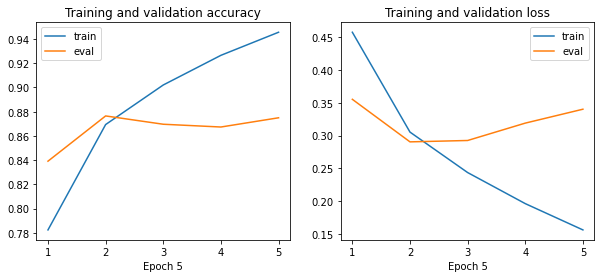

In [13]:
import matplotlib.pyplot as plt

fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 4))
epoch = [1,2,3,4,5]
plt1.plot(epoch, train_acc_lists, label='train')
plt1.plot(epoch, eval_acc_lists, label='eval')
plt1.set_title('Training and validation accuracy')
plt1.legend()
plt1.set(xlabel='Epoch 5')

plt2.plot(epoch, train_loss_lists, label='train')
plt2.plot(epoch, eval_loss_lists, label='eval')
plt2.set_title('Training and validation loss')
plt2.legend()
plt2.set(xlabel='Epoch 5')

In [14]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)

100%|██████████| 42/42 [00:08<00:00,  5.14it/s]

      index   label
0         0  Non_HS
1         1      HS
2         2      HS
3         3  Non_HS
4         4  Non_HS
...     ...     ...
1308   1308  Non_HS
1309   1309  Non_HS
1310   1310      HS
1311   1311  Non_HS
1312   1312  Non_HS

[1313 rows x 2 columns]


In [15]:
pred = pd.read_csv('pred.txt')

In [16]:
daftar_prediksi = []

for i in pred['label'] : 
  if i == 'Non_HS': 
    daftar_prediksi.append(0)
  else :
    daftar_prediksi.append(1)


In [17]:
data_test = pd.read_csv('DataTestInt.csv')

Accuracy score is 89%.

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       750
           1       0.88      0.87      0.87       563

    accuracy                           0.89      1313
   macro avg       0.89      0.89      0.89      1313
weighted avg       0.89      0.89      0.89      1313


Confusion Matrix:


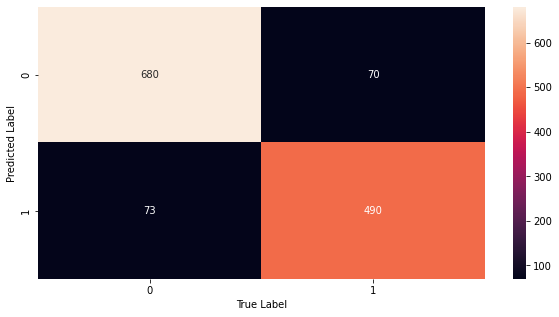

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

accuracy = accuracy_score(data_test['hs_class'], daftar_prediksi) * 100
print("Accuracy score is {}%." .format(round(accuracy),1))
print()
print("Classification Report:")
print(classification_report(data_test['hs_class'], daftar_prediksi))

print("\nConfusion Matrix:")
f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix(data_test['hs_class'], daftar_prediksi), annot=True, fmt=".0f", ax=ax)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()

In [ ]:
text = 'terima kasih pak gubernur atas pujiannya'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: terima kasih pak gubernur atas pujiannya | Label : Non_HS (99.812%)


In [ ]:
print(logits)

tensor([[ 3.4212, -2.8559]], device='cuda:0')


In [ ]:
print(torch.topk(logits, 1))

torch.return_types.topk(
values=tensor([[3.4212]], device='cuda:0'),
indices=tensor([[0]], device='cuda:0'))


#**SAVE MODEL**

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


In [ ]:
import pickle

# saving
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls -l --block-size=K ./model_save/

total 487040K
-rw-r--r-- 1 root root      1K Aug 29 17:20 config.json
-rw-r--r-- 1 root root 486188K Aug 29 17:20 pytorch_model.bin
-rw-r--r-- 1 root root      1K Aug 29 17:20 special_tokens_map.json
-rw-r--r-- 1 root root      1K Aug 29 17:44 tokenizer_config.json
-rw-r--r-- 1 root root    612K Aug 29 17:52 tokenizer.pkl
-rw-r--r-- 1 root root    224K Aug 29 17:20 vocab.txt


**Perbandingan Label yang diprediksi dan label asli**



In [ ]:
jumlah_0_asli = 0
jumlah_1_asli = 0

for i in data_test['hs_class'] :
  if i == 0 :
    jumlah_0_asli += 1
  else :
    jumlah_1_asli += 1

print(jumlah_0_asli)
print(jumlah_1_asli)

750
563


In [ ]:
jumlah_0_pred = 0
jumlah_1_pred = 0

for i in daftar_prediksi :
  if i == 0 :
    jumlah_0_pred += 1
  else :
    jumlah_1_pred += 1

print(jumlah_0_pred)
print(jumlah_1_pred)

753
560


[]

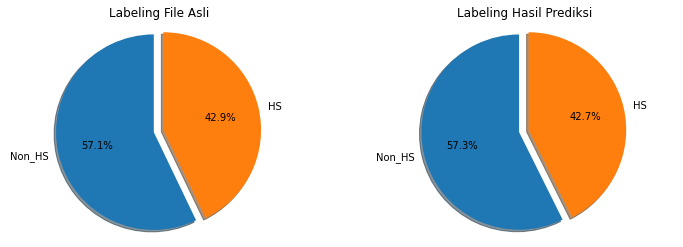

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# File Asli
labels = 'Non_HS', 'HS'
sizes = [jumlah_0_asli, jumlah_1_asli]
explode = (0.1, 0)

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Labeling File Asli')

#Hasil Prekdiksi
labels = 'Non_HS', 'HS'
sizes = [jumlah_0_pred, jumlah_1_pred]
explode = (0.1, 0)

ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')
ax2.set_title('Labeling Hasil Prediksi')

ax1.plot()
ax2.plot()